In [1]:
#Perform EuroSat classification using VIT
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve, average_precision_score
from tqdm.auto import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import random
from torch.utils.data import Subset
random.seed(42)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import vision_transformer as vits

In [3]:
init = [None,"IMAGENET1K_V1", "IMAGENET1K_SWAG_E2E_V1"]
backbone = models.vit_b_16
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
training_type = ['fine_tuning', 'linear_probe']
batch_size = 64  
num_epochs = 20
lr = 0.001  
weight_decay = 0.0005

cuda:0


In [4]:
def select_percentage_of_train_dataset(dataset, percentage):
    class_counts = {}
    indices_by_class = {}
    # Count the number of samples in each class
    for idx, (_, label) in enumerate(dataset):
        if label not in class_counts:
            class_counts[label] = 0
            indices_by_class[label] = []
        class_counts[label] += 1
        indices_by_class[label].append(idx)

    selected_indices = []

    # Select a percentage of samples from each class
    for _, indices in indices_by_class.items():
        num_samples = int(len(indices) * percentage)
        selected_samples = random.sample(indices, num_samples)
        selected_indices.extend(selected_samples)

    selected_data = Subset(dataset, selected_indices)
    return selected_data

def model_def(backbone, training_type, weights, num_classes, device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model = backbone(weights=weights)
    model.heads.head = nn.Linear(in_features=model.heads.head.in_features, out_features=num_classes)

    if training_type == 'fine_tuning':
        for param in model.parameters():
            param.requires_grad = True
    elif training_type == 'linear_probe':
        for param in model.parameters():
            param.requires_grad = False
        for param in model.heads.head.parameters():
            param.requires_grad = True
    else:
        raise ValueError('Invalid training type!')
    return model.to(device)

def evaluate_model(model, test_loader, criterion, device):
    model.eval()  
    test_loss = 0.0
    correct = 0
    total = 0


    with torch.no_grad():
        for inputs, labels in test_loader:
            if device:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    test_loss /= len(test_loader.dataset)
    accuracy = 100 * correct / total

    return accuracy, test_loss

def train_model(model, selected_train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device, save_dir):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    best_acc = 0.0
    best_loss = float('inf')

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch} of {num_epochs}')
        correct = 0
        iterations = 0
        iter_loss = 0.0
        total = 0

        model.train()  

        for i, (inputs, labels) in enumerate(selected_train_loader):
            if device:
                inputs = inputs.to(device)
                labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            iter_loss += loss.item() 
            optimizer.zero_grad() 
            loss.backward()  
            optimizer.step()  

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        scheduler.step()

        train_loss.append(iter_loss / iterations)
        train_accuracy.append(100 * correct / total)

        test_acc, test_losses = evaluate_model(model, test_loader, criterion, device)

        test_loss.append(test_losses)
        test_accuracy.append(test_acc)

        print(f'Epoch {epoch} Train results: Loss={train_loss[-1]:.4f} | Accuracy={train_accuracy[-1]:.2f}%')
        print(f'Epoch {epoch} Test results: Loss={test_loss[-1]:.4f} | Accuracy={test_accuracy[-1]:.2f}%\n')

        if test_acc > best_acc:
            best_acc = test_acc
            # torch.save(model.state_dict(), os.path.join(save_dir, 'best_acc_model.pth'))

        if test_losses < best_loss:
            best_loss = test_losses
            # torch.save(model.state_dict(), os.path.join(save_dir, 'best_loss_model.pth'))
    return train_loss, train_accuracy, test_loss, test_accuracy


In [5]:
dataset_path = "/home/akansh-i2sc/Desktop/Study/HLCV/Why-Self-Supervision-in-Time/data/EuroSAT/"
#Data transforms and dataloaders
data_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [6]:
from collections import Counter
print(dict(Counter(test_dataset.targets)))

{0: 300, 1: 300, 2: 300, 3: 250, 4: 250, 5: 200, 6: 250, 7: 300, 8: 250, 9: 300}


In [7]:
percentage_list = np.arange(0.0, 1.1, 0.10)
percentage_list[0] = 0.01

In [8]:
save_dir = "/home/idisc02/Desktop/Hewan/hlcv/Why-Self-Supervision-in-Time/src/models"
train_acc_dict_percentage = {}
test_acc_dict_percentage = {}
train_loss_dict_percentage = {}
test_loss_dict_percentage = {}

for k in tqdm(init):
    print(k)
    for j in tqdm(training_type):
        print(j)
        for i in tqdm(range(len(percentage_list))):
            print(f'Percentage of the dataset used: {percentage_list[i]}')
            model = model_def(backbone, j, k, num_classes, device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
            selected_train_dataset = select_percentage_of_train_dataset(train_dataset, percentage_list[i])
            selected_train_loader = DataLoader(selected_train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
            train_loss, train_accuracy, test_loss, test_accuracy = train_model(model, selected_train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device, save_dir)

            train_acc_dict_percentage[f"{k}_{j}_{percentage_list[i]}"] = train_accuracy
            test_acc_dict_percentage[f"{k}_{j}_{percentage_list[i]}"] = test_accuracy
            train_loss_dict_percentage[f"{k}_{j}_{percentage_list[i]}"] = train_loss
            test_loss_dict_percentage[f"{k}_{j}_{percentage_list[i]}"] = test_loss

  0%|          | 0/3 [00:00<?, ?it/s]

None


  0%|          | 0/2 [00:00<?, ?it/s]

fine_tuning


  0%|          | 0/11 [00:00<?, ?it/s]

Percentage of the dataset used: 0.01
Epoch 1 of 20


AssertionError: Wrong image height! Expected 224 but got 64!

In [27]:
test_acc_dict_percentage.keys()

dict_keys(['None_fine_tuning_0.01', 'None_fine_tuning_0.1', 'None_fine_tuning_0.2', 'None_fine_tuning_0.30000000000000004', 'None_fine_tuning_0.4', 'None_fine_tuning_0.5', 'None_fine_tuning_0.6000000000000001', 'None_fine_tuning_0.7000000000000001', 'None_fine_tuning_0.8', 'None_fine_tuning_0.9', 'None_fine_tuning_1.0', 'None_linear_probe_0.01', 'None_linear_probe_0.1', 'None_linear_probe_0.2', 'None_linear_probe_0.30000000000000004', 'None_linear_probe_0.4', 'None_linear_probe_0.5', 'None_linear_probe_0.6000000000000001', 'None_linear_probe_0.7000000000000001', 'None_linear_probe_0.8'])

In [28]:
None_fine_tuning = []
None_linear_probe = []
Imagenetv1_fine_tuning = []
Imagenetv2_fine_tuning = []
Imagenetv1_fine_tuning_linear_probe = []
Imagenetv2_fine_tuning_linear_probe = []

for i in percentage_list:
    key = f"None_fine_tuning_{i}"
    None_fine_tuning.append(np.max(test_acc_dict_percentage[key]))
    key = f"None_linear_probe_{i}"
    None_linear_probe.append(np.max(test_acc_dict_percentage[key]))
    # key = f"ResNet50_Weights.IMAGENET1K_V1_fine_tuning_{i}"
    # Imagenetv1_fine_tuning.append(np.max(test_acc_dict_percentage[key]))
    # key = f"ResNet50_Weights.IMAGENET1K_V2_fine_tuning_{i}"
    # Imagenetv2_fine_tuning.append(np.max(test_acc_dict_percentage[key]))
    # key = f"ResNet50_Weights.IMAGENET1K_V1_linear_probe_{i}"
    # Imagenetv1_fine_tuning_linear_probe.append(np.max(test_acc_dict_percentage[key]))
    # key = f"ResNet50_Weights.IMAGENET1K_V2_linear_probe_{i}"
    # Imagenetv2_fine_tuning_linear_probe.append(np.max(test_acc_dict_percentage[key]))



KeyError: 'None_linear_probe_0.9'

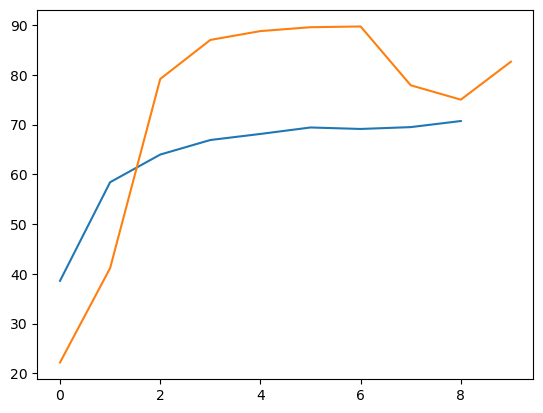

In [31]:
plt.plot(None_linear_probe)
plt.plot(None_fine_tuning)

In [ ]:
#plot all the list with legend
plt.figure(figsize=(12, 8))
plt.plot(percentage_list, None_fine_tuning, label='Random Initialization', marker= 'o')
plt.plot(percentage_list, Imagenetv1_fine_tuning, label='Imagenetv1 Initialization', marker= 'o')
plt.plot(percentage_list, Imagenetv2_fine_tuning, label='Imagenetv2 Initialization', marker= 'o')
plt.xlabel('Percentage of the dataset used')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Percentage of the dataset used(Fine-tuning)[EuroSAT]')
plt.savefig('/home/idisc02/Desktop/Hewan/hlcv/Why-Self-Supervision-in-Time/data/assets/finetuning.png')